In [25]:
import pickle as pkl

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from matplotlib import pyplot as plt

**Load data**

In [33]:
with open(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/model=slow-50-tap/model=slow-50_mathod=tap_partition=test-feats_clips=4.pkl",
    "rb",
) as f:
    data = pkl.load(f)

metadata = pd.read_csv(
    "/home/dl18206/Desktop/phd/data/panaf/PanAfFull/notebooks/data/panaf-seq_metadata.csv"
)

**Preprocess**

In [34]:
behaviours = [
    "aggression",
    "bipedal",
    "camera_reaction",
    "climbing",
    "display",
    "feeding",
    "grooming",
    "object_carrying",
    "piloerection",
    "playing",
    "resting",
    "tool_use",
    "travel",
    "vocalisation",
]

behaviours_dict = {beh: i for i, beh in enumerate(behaviours)}

In [35]:
# Detach all tensors and move to CPU
for k, v in data.items():
    if k not in ["names"]:
        data[k] = v.detach().cpu()

In [36]:
# Apply softmax across all logits
logits = F.sigmoid(data["cas"])

logit_df = pd.DataFrame(
    logits.tolist(), columns=["clip_1", "clip_2", "clip_3", "clip_4"]
)

# Get the names of the clips
name_df = pd.DataFrame(data["names"], columns=["name"])
name_df = name_df.merge(
    metadata[["subject_id", "value"]], left_on="name", right_on="subject_id"
).drop(columns=["subject_id"])

# Concatenate the two dataframes
df = pd.concat([name_df, logit_df], axis=1)

**Concat all clip predictions over all videos**

In [37]:
# Store all concatenated clips in a list
clips = []

# Iterate through all rows of df
for i, row in df.iterrows():
    item = {}

    name = row["name"]
    seq = row.value

    clip_1 = row.clip_1
    clip_2 = row.clip_2
    clip_3 = row.clip_3
    clip_4 = row.clip_4

    # Convert all to numpy arrays
    clip_1 = np.array(clip_1).reshape(-1, 14)
    clip_2 = np.array(clip_2).reshape(-1, 14)
    clip_3 = np.array(clip_3).reshape(-1, 14)
    clip_4 = np.array(clip_4).reshape(-1, 14)

    # Concat clips along the time axis
    clip = np.concatenate([clip_1, clip_2, clip_3, clip_4], axis=0)

    item["name"] = name
    item["seq"] = seq
    item["clip"] = clip

    clips.append(item)

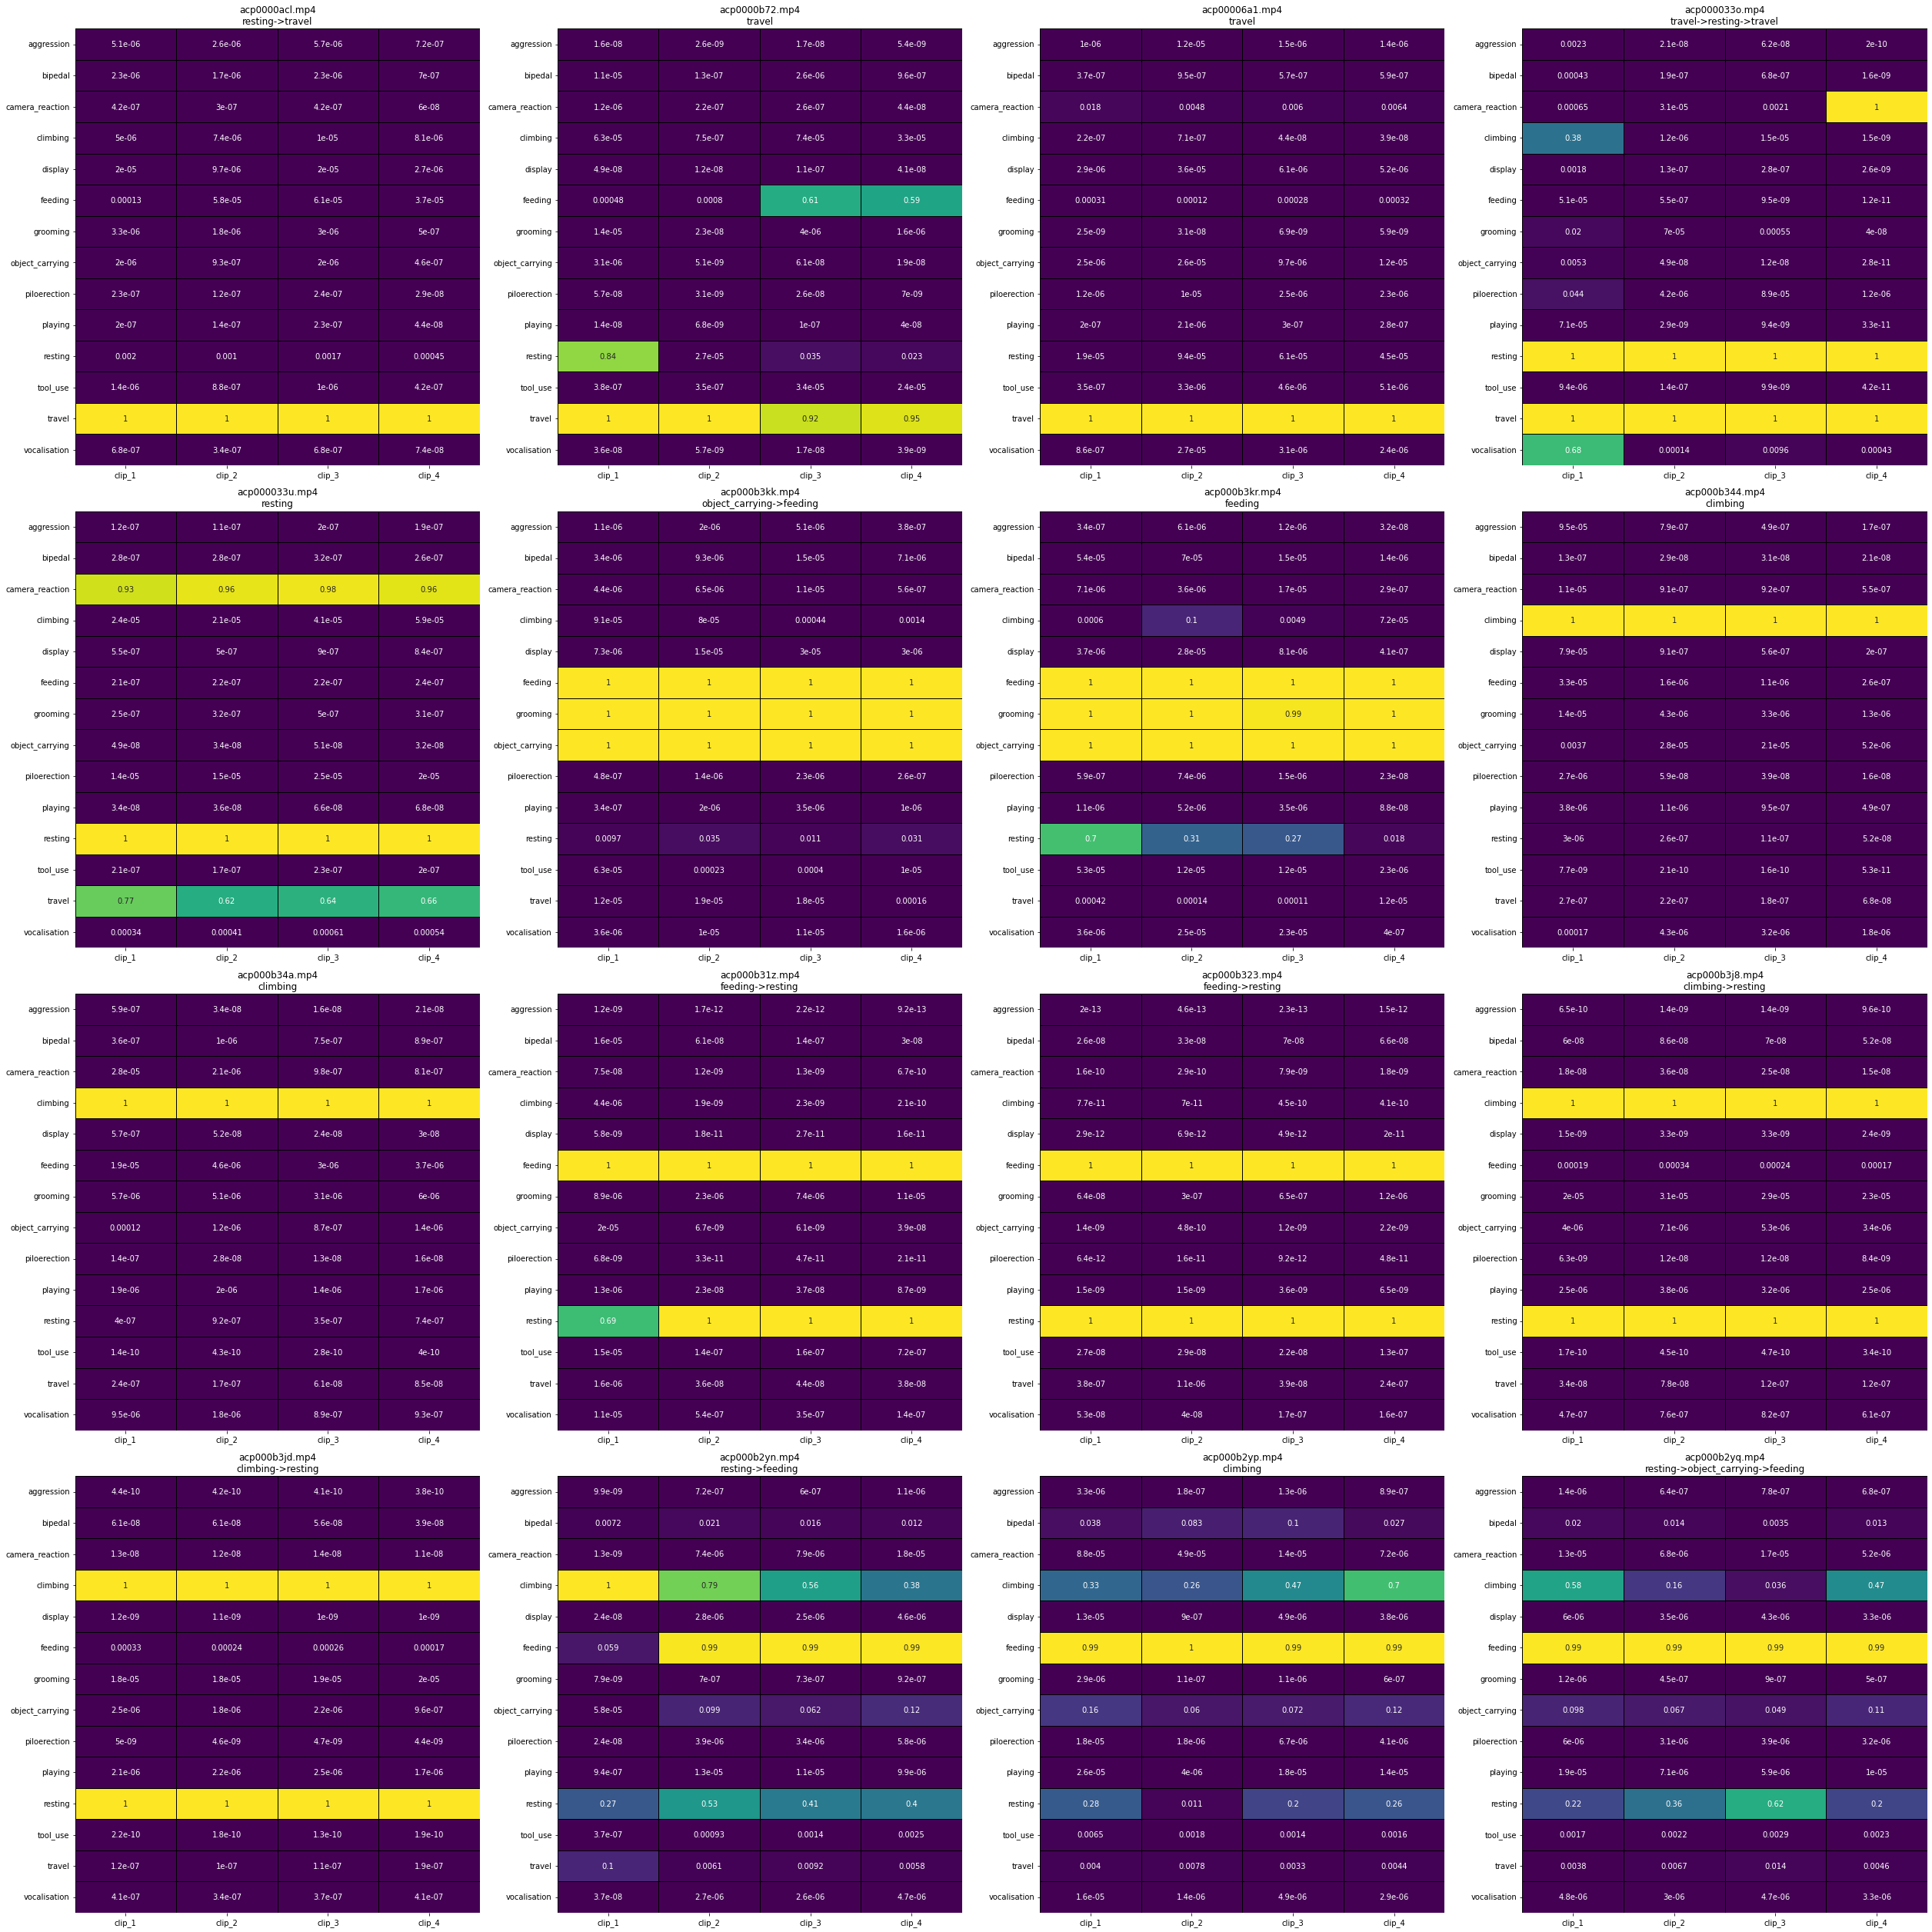

In [38]:
# Plot the clips in 4 x N grid
plt.figure(figsize=(35, 35))
for i, clip in enumerate(clips[16:32]):
    plt.subplot(4, 4, i + 1)
    sns.heatmap(
        clip["clip"].transpose(),
        cmap="viridis",
        yticklabels=behaviours,
        xticklabels=["clip_1", "clip_2", "clip_3", "clip_4"],
        annot=True,
        linewidths=0.5,
        linecolor="black",
        cbar=False,
    )
    plt.title(f'{clip["name"]}\n{"->".join(clip["seq"].split(","))}')
plt.tight_layout()
plt.show()

In [24]:
df[df.name == "acp000b2yn.mp4"].clip_3.values

array([list([5.978624244562525e-07, 0.015507067553699017, 7.894500413385686e-06, 0.560591995716095, 2.4807784484437434e-06, 0.9923099279403687, 7.344083883253916e-07, 0.062478095293045044, 3.3567173431947595e-06, 1.0792015928018373e-05, 0.4073466956615448, 0.0014351938152685761, 0.009196965023875237, 2.553078502387507e-06])],
      dtype=object)